# WaveRNN - Fit a Short Sample

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, sys, math
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
from utils.display import *
from utils.dsp import *
from models.wavernn import WaveRNN

In [2]:
notebook_name = 'nb2'
sample_rate = 22050

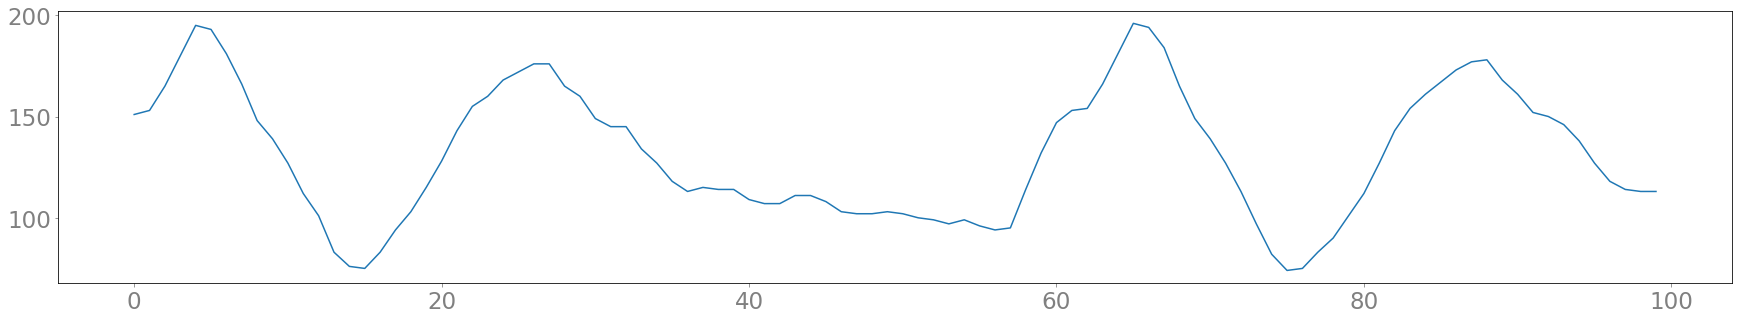

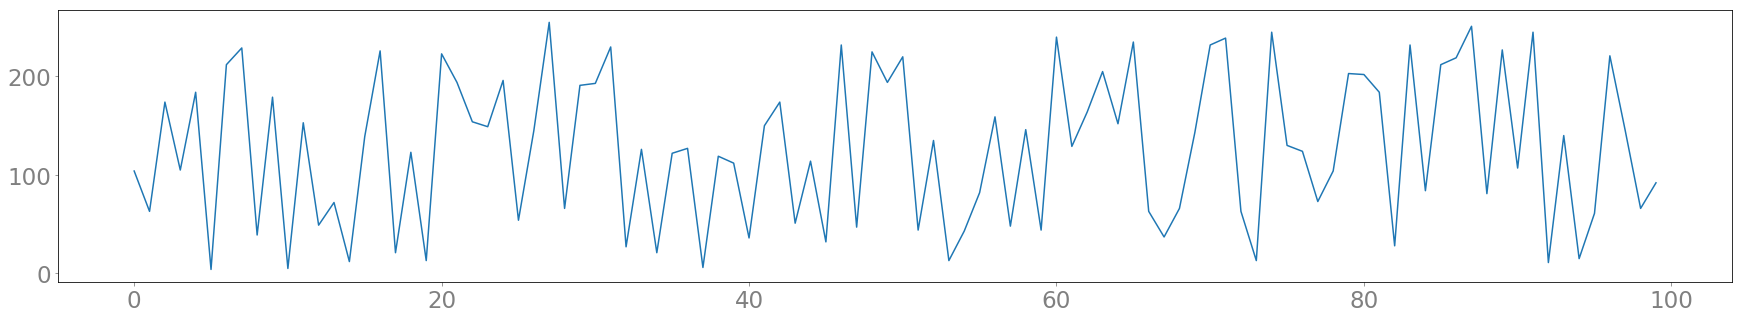

In [3]:
sample = wavfile.read('data/female_vocal_op8_8.wav')[1]
coarse_classes, fine_classes = split_signal(sample)

plot(coarse_classes[3000:3100])
plot(fine_classes[3000:3100])

## Instantiate Model and Train

In [4]:
model = WaveRNN().cuda()

Trainable Parameters: 3.050 million


In [5]:
coarse_classes, fine_classes = split_signal(sample)

In [6]:
batch_size = 32
coarse_classes = coarse_classes[:len(coarse_classes) // batch_size * batch_size]
fine_classes = fine_classes[:len(fine_classes) // batch_size * batch_size]
coarse_classes = np.reshape(coarse_classes, (batch_size, -1))
fine_classes = np.reshape(fine_classes, (batch_size, -1))

In [7]:
coarse_classes.shape

(32, 2521)

In [8]:
def train(model, optimizer, num_steps, batch_size, seq_len=960) :
    
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :
        
        loss = 0
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        for i in range(seq_len) :
            
            j = rand_idx + i
            
            x_coarse = coarse_classes[:, j:j + 1]
            x_fine = fine_classes[:, j:j + 1]
            x_input = np.concatenate([x_coarse, x_fine], axis=1)
            x_input = x_input / 127.5 - 1.
            x_input = torch.FloatTensor(x_input).cuda()
            
            y_coarse = coarse_classes[:, j + 1]
            y_fine = fine_classes[:, j + 1]
            y_coarse = torch.LongTensor(y_coarse).cuda()
            y_fine = torch.LongTensor(y_fine).cuda()
            
            current_coarse = y_coarse.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, y_coarse)
            loss_fine = F.cross_entropy(out_fine, y_fine)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.item() / seq_len)
        loss.backward()
        optimizer.step()
        
        speed = (step + 1) / (time.time() - start)
        
        stream('Step: %i/%i --- Loss: %.2f --- Speed: %.1f batches/second ',
              (step + 1, num_steps, running_loss / (step + 1), speed))      

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
train(model, optimizer, num_steps=1000, batch_size=batch_size)

Step: 1000/1000 --- Loss: 6.08 --- Speed: 0.9 batches/second 

### Generate

In [18]:
output, c, f = model.generate(10000)

Gen: 10000/10000 -- Speed: 1186

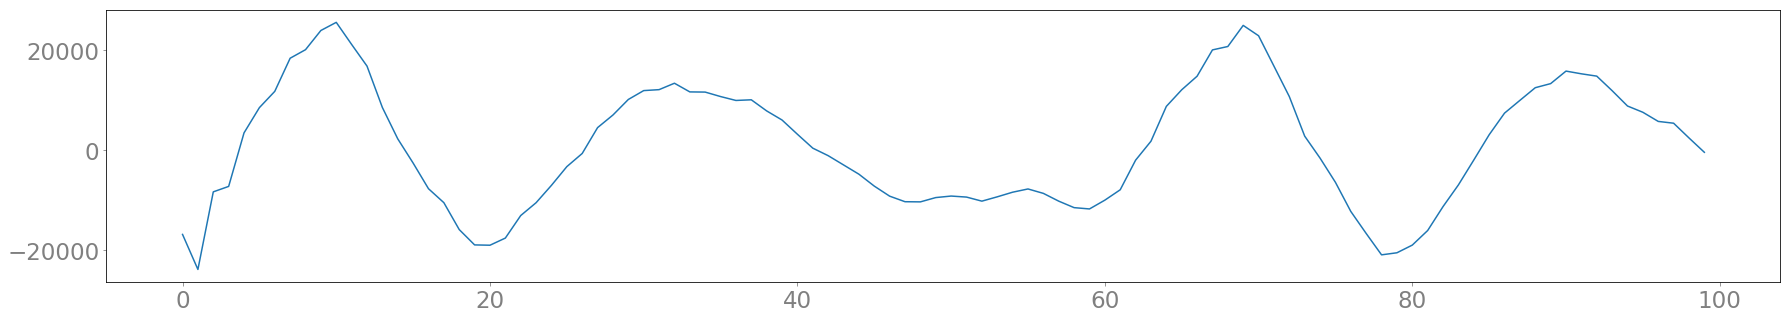

In [19]:
plot(output[:100])

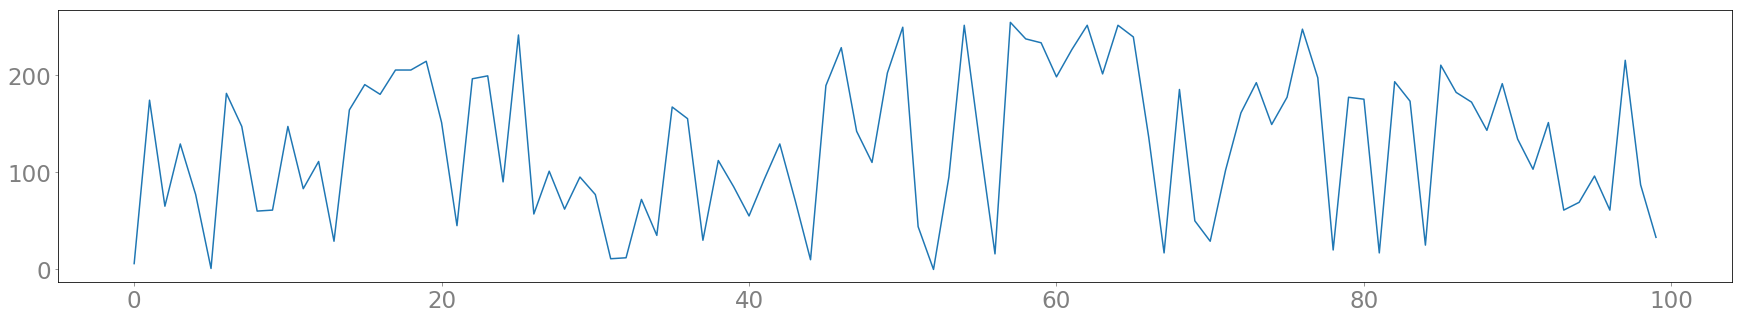

In [20]:
plot(f[:100])

In [21]:
def save_wav(y, filename, sample_rate) :
    y = np.clip(y, -2**15, 2**15 - 1)
    wavfile.write(filename, sample_rate, y.astype(np.int16))

In [22]:
save_wav(output, f'outputs/{notebook_name}/1k_steps.wav', sample_rate)